# Bland-Altman analysis
The functions related to Bland-Altman analysis and generation of plots are adapted from the code written by Dr. Rowan Nicolls
https://rowannicholls.github.io/python/statistics/agreement/bland_altman.html

In [1]:
from skimage.io import imread, imsave
import pyclesperanto_prototype as cle
import napari
import os
import numpy as np
import pandas as pd
from aicsimageio import AICSImage
from skimage.feature import peak_local_max
import warnings
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
def segmentation(image, threshold):
    
    #Noise removal
    g_blur = cle.gaussian_blur(image, sigma_x=1, sigma_y=1, sigma_z=1)
    
    #background subtracton
    background_subtracted = np.asarray(cle.top_hat_box(g_blur, radius_x=2*3, radius_y=2*3, radius_z=2*3))
    del g_blur
    
    #threshold = threshold_otsu(background_subtracted)
    peaks = peak_local_max(background_subtracted, threshold_abs=threshold, min_distance=2)
    
    # Find local peaks above the specified threshold
    spots = cle.create(image.shape, dtype=np.uint32)
    peaks = peaks[:,::-1]
        
    # Convert the list of peaks to a labeled image
    labeled_spots = cle.pointlist_to_labelled_spots(peaks.T, spots)
    
    # Expand the labeled spots by a certain radius
    expanded_labels = cle.dilate_labels(labeled_spots, radius=5)
    
    #Create a binary mask where all pixels above half of the maximum intensity in each labels are 1
    #This is done to perform full-width half-maxima for estimating foci boundary
    threshold_map = cle.maximum_intensity_map(background_subtracted, expanded_labels) / 2
    thresholded_image = np.asarray(background_subtracted) > np.asarray(threshold_map)
    
    labeled_foci = (expanded_labels * thresholded_image).astype(np.uint32)
    
    #Exclude small labels
    output_labels = cle.exclude_small_labels(labeled_foci, None, 10.0)
    
    del peaks
    del background_subtracted
    del spots
    del labeled_spots
    del labeled_whatever
    del expanded_labels
    del threshold_map
    del thresholded_image
    del image
    
    return output_labels

In [3]:
def measure_foci_count(BA_folder, threshold):
    y=[]

    for file_name in file_names:
        if file_name.endswith('.tif'):
            image_path = os.path.join(BA_folder, file_name)
            img = AICSImage(image_path)
            img_data =  img.get_image_data("ZYX", T=0, C=0)
            labels = segmentation(img_data, threshold)
            y.append(labels.max())
            
    y = pd.DataFrame([int(i) for i in y], columns= [str(threshold)])
    return y

In [4]:
def bland_altman_analysis(df):
    """Calculate agreement statistics."""
    tests = list(df)

    # Individual subject calculations
    df['Means'] = df[tests].mean(axis=1)
    df['Differences'] = df[tests].diff(axis=1)[tests[-1]]
    df['s'] = df[tests].std(axis=1, ddof=1)
    df['var'] = df['s']**2

    # Whole sample calculations
    summary = pd.DataFrame()
    means = ['Mean of ' + test for test in tests]
    for i, mean in enumerate(means):
        summary.loc[1, mean] = df[tests[i]].mean()
    # Sample size
    summary.loc[1, 'n'] = df.shape[0]
    # Degrees of freedom
    summary.loc[1, 'DOF'] = df.shape[0] - 1
    # Bias (mean difference)
    mean_diff = df['Differences'].mean()
    summary.loc[1, 'Bias'] = mean_diff
    # Sample standard deviations of the differences
    s_diff = df['Differences'].std(ddof=1)
    summary.loc[1, 's'] = s_diff
    summary.loc[1, 'Lower LOA'] = mean_diff - 1.96 * s_diff
    summary.loc[1, 'Upper LOA'] = mean_diff + 1.96 * s_diff
    # Within-subject standard deviation
    s_w = np.sqrt(df['var'].mean())
    summary.loc[1, 'Within-Subject SD (Sw)'] = s_w
    # Coefficient of repeatability
    col = 'Repeatability Coefficient (RC)'
    summary.loc[1, col] = np.sqrt(2) * 1.96 * s_w

    # Return
    return df, summary

In [5]:
BA_folder = r'C:\Nisarg\Thesis\Data\Bland-Altman\W33'

In [6]:
#Counting number of foci in manually annotated crops

file_names = os.listdir(BA_folder)
x=[]

warnings.filterwarnings("ignore")  #This line is only here to create proper presentation of results

for file_name in file_names:
    if file_name.endswith('.csv'):
        x.append(np.atleast_1d(np.recfromtxt(os.path.join(BA_folder, file_name))).shape[0])
        
true_labels_df = pd.DataFrame(x, columns=['true_labels'])
print(true_labels_df)

   true_labels
0            2
1           25
2            2
3            2
4           12
5            9
6            5
7           13
8           10
9            8


In [7]:
threshold_list = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

In [8]:
#Calculating foci count using thresholds from threshold_list

list_of_df = []

for threshold in threshold_list:
    y = measure_foci_count(BA_folder, threshold)
    list_of_df.append(y)
    
list_of_df.append(true_labels_df)
table = pd.concat(list_of_df, axis = 1)
table

,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,true_labels
0,46,7,2,2,2,2,2,2,2,2
1,28,26,22,18,17,16,11,11,9,25
2,38,6,1,1,1,1,1,1,1,2
3,39,9,2,2,2,2,2,2,2,2
4,11,9,7,6,5,5,4,3,2,12
5,39,13,11,10,10,10,10,9,9,9
6,44,9,5,5,5,5,5,5,3,5
7,16,14,12,10,10,9,7,7,7,13
8,10,10,9,9,7,7,7,7,7,10
9,10,9,8,6,6,6,6,5,4,8


In [10]:
#Saving foci count calculated from corresponding threshold
table.to_csv('W33_table.csv', index_label='index')

## Extracting the difference of Limits of aggeements from Bland-Altman analysis

In [9]:
warnings.filterwarnings("ignore")  #This line is only here to create proper presentation of results

list_of_diff_of_loas_df=[]
for i in threshold_list:
    df = table[['true_labels', str(i)]]
    df, summary = bland_altman_analysis(df)
    diff_of_loas_df = pd.DataFrame((summary['Upper LOA'] - summary['Lower LOA']), columns=[str(i)])
    list_of_diff_of_loas_df.append(diff_of_loas_df)
diff_of_loas_summary = pd.concat(list_of_diff_of_loas_df, axis=1)
diff_of_loas_summary

,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1
1,75.290537,11.421194,7.494847,10.526577,11.982924,12.968296,18.575819,18.589601,20.477597


In [63]:
diff_of_loas_summary.to_csv('W33_BA_LoA_summary.csv', index_label='index')

## Generating Bland-Altman plot for optimal threshold

In [10]:
x = table['true_labels']
y = table['0.04']
print(x,y, x.dtype)

0     2
1    25
2     2
3     2
4    12
5     9
6     5
7    13
8    10
9     8
Name: true_labels, dtype: int64 0     2
1    22
2     1
3     2
4     7
5    11
6     5
7    12
8     9
9     8
Name: 0.04, dtype: int64 int64


In [12]:
means = (x + y) / 2
diffs = y - x


In [23]:
# Average difference (aka the bias)
bias = np.mean(diffs)
# Sample standard deviation
s = np.std(diffs, ddof=1)  # Use ddof=1 to get the sample standard deviation

print(f'For the differences, x̄ = {bias:.2f} and s = {s:.2f}')

For the differences, x̄ = -0.90 and s = 1.91


In [24]:
# Limits of agreement (LOAs)
upper_loa = bias + 1.96 * s
lower_loa = bias - 1.96 * s

print(f'The limits of agreement are {upper_loa:.2f} and {lower_loa:.2f}')

The limits of agreement are 2.85 and -4.65


In [25]:
# Confidence level
C = 0.95  # 95%

# Significance level, α
alpha = 1 - C

# Number of tails
tails = 2

# Quantile (the cumulative probability)
q = 1 - (alpha / tails)

# Critical z-score, calculated using the percent-point function (aka the
# quantile function) of the normal distribution
z_star = st.norm.ppf(q)

print(f'95% of normally distributed data lies within {z_star}σ of the mean')

95% of normally distributed data lies within 1.959963984540054σ of the mean


In [26]:
# Limits of agreement (LOAs)
loas = (bias - z_star * s, bias + z_star * s)

print(f'The limits of agreement are {loas}')

The limits of agreement are (-4.647354551337023, 2.847354551337023)


In [27]:
# Limits of agreement (LOAs)
loas = st.norm.interval(C, bias, s)

print(np.round(loas, 2))

[-4.65  2.85]


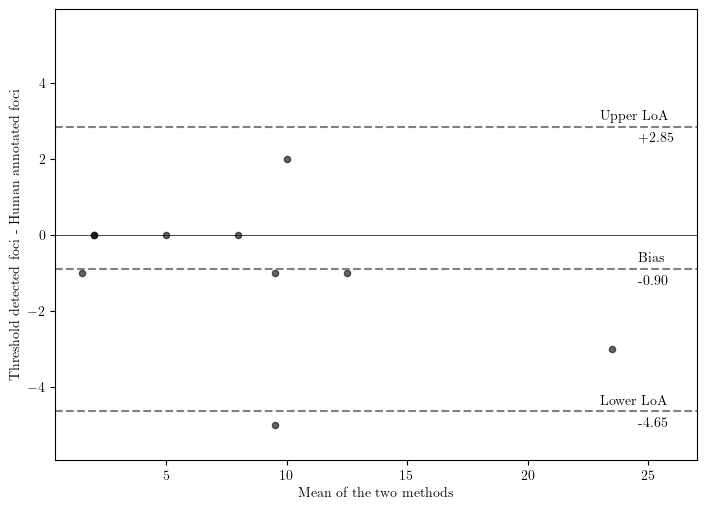

In [30]:
# Create plot
ax = plt.axes()
ax.scatter(means, diffs, c='k', s=20, alpha=0.6, marker='o')
# Plot the zero line
ax.axhline(y=0, c='k', lw=0.5)
# Plot the bias and the limits of agreement
ax.axhline(y=loas[1], c='grey', ls='--')
ax.axhline(y=bias, c='grey', ls='--')
ax.axhline(y=loas[0], c='grey', ls='--')
# Labels
#ax.set_title('Bland-Altman Plot for Two Methods of Measuring PEFR')
ax.set_xlabel('Mean of the two methods')
ax.set_ylabel('Threshold detected foci - Human annotated foci')
# Get axis limits
left, right = ax.get_xlim()
bottom, top = ax.get_ylim()
# Set y-axis limits
max_y = max(abs(bottom), abs(top))
ax.set_ylim(-max_y * 1.1, max_y * 1.1)
# Set x-axis limits
domain = right - left
ax.set_xlim(left, left + domain * 1.1)
# Annotations
ax.annotate('Upper LoA', (right-1.6, upper_loa), (0, 7), textcoords='offset pixels')
ax.annotate(f'{upper_loa:+4.2f}', (right, upper_loa+0.25), (0, -25), textcoords='offset pixels')
ax.annotate('Bias', (right, bias), (0, 7), textcoords='offset pixels')
ax.annotate(f'{bias:+4.2f}', (right, bias+0.25), (0, -25), textcoords='offset pixels')
ax.annotate('Lower LoA', (right-1.6, lower_loa), (0, 7), textcoords='offset pixels')
ax.annotate(f'{lower_loa:+4.2f}', (right, lower_loa+0.25), (0, -25), textcoords='offset pixels')

# Show plot
plt.show()